### The beginning of maybe more than just a bathtub

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import pylab
import time

In [2]:
hor_dist = np.arange(0,2000)
slope = np.radians(24)
glacier_length = 1200 # m 
width = 1 #m
bed = np.max(np.tan(slope)*hor_dist)-np.tan(slope)*hor_dist
ice_thickness = 50 #meters
glacier = bed.copy()
glacier[50:50+glacier_length]+=ice_thickness 
rho_water = 1000 #kg/m3
rho_ice = 917 #kg/m3
g = 9.81 #m/s2
porosity = 1
k = 0.2 # hydraulic conductivity

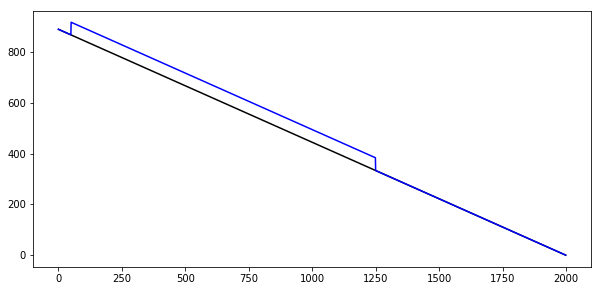

In [3]:
plt.figure(figsize=(10,10))
plt.gca().set_aspect('equal', adjustable='box')
plt.plot(hor_dist,bed,'k')
plt.plot(hor_dist,glacier,'b')
plt.show()

In [4]:
max_runtime = 100
precip = np.ones(max_runtime)*0.002 # m/hour
runtime = np.arange(0,max_runtime,1) # hours
h_water = np.zeros(max_runtime)

for t in range(0,len(runtime)-1):
    h_water[t] += precip[t]
    h_water[t] += (-k*h_water[t])/porosity
    h_water[t+1] = h_water[t]


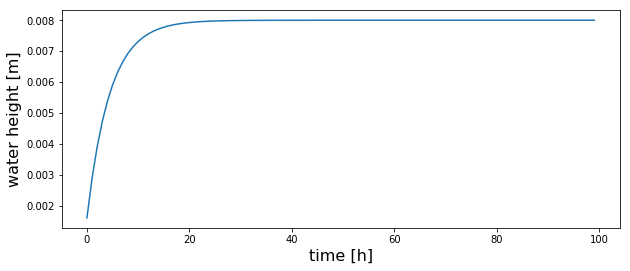

In [5]:
plt.figure(figsize=(10,4))
plt.plot(runtime,h_water)
plt.xlabel('time [h]',fontsize = 16)
plt.ylabel('water height [m]',fontsize = 16)
plt.show()

In [6]:
ratio = (h_water*rho_water*g)/(ice_thickness*rho_ice*g)

In [7]:
%%capture
chisana = pd.read_csv('ChisanaMeteo.csv',',',header=None, 
 names = ['date','P_cum','T_avg','T_max','T_min','T_obs','P_inc'],na_values=['-99.900000000000006'])
chisana.date = pd.to_datetime(chisana.date, format='%d/%m/%y')
hor_dist_chisana = np.arange(0,len(chisana.P_inc))
profile_2014 = pd.read_csv('2014_bed_profile.txt','\t',header=None,
                           names=['hor_dist','x','y','elevation'])
profile_2016 = pd.read_csv('2016_bed_profile.txt','\t',header=None,
                           names=['hor_dist','x','y','elevation'])
h_ice = profile_2014['elevation']-profile_2016['elevation']
h_ice[h_ice<0] = 0


In [8]:
chisana.P_inc = chisana.P_inc.fillna(0)
chisana.T_max = chisana.T_max.fillna(method='ffill') # if T is NaN, use last known value

### Build numerical model

In [23]:
max_runtime = len(chisana.date)
runtime = np.arange(0,max_runtime,1) # days
dx = 5 #m
dt = 1 # day
phi = 0.05
width = 1 #m
mean_ice_thickness = h_ice.as_matrix().reshape(-1,dx).mean(axis=1)
mean_ice_thickness = mean_ice_thickness[3:] # drop first four cells that have negligible thickness.
mean_bed_elevation = profile_2016.elevation.as_matrix().reshape(-1, dx).mean(axis=1)
mean_bed_elevation = mean_bed_elevation[3:] # drop first four cells that have negligible thickness.
mean_hor_dist = profile_2016.hor_dist.as_matrix().reshape(-1, dx).mean(axis=1)
mean_hor_dist = mean_hor_dist[3:]
h_cell = np.zeros(len(mean_ice_thickness)+2)
dz_to_station = (mean_bed_elevation-1012)/1000
T_flatcreek = np.zeros(len(dz_to_station))
lapsrate = 6 # deg C per km$
pos_deg_day_melt = 6/1000. # melt per day per positive degree
water_level_matrix = np.zeros((len(runtime),len(mean_bed_elevation)))
effective_idx = len(T_flatcreek) # start out considering whole glacier as ineffective

In [24]:
for t in range(0, len(runtime)-1):
#for t in range(0, 10):
    T_flatcreek = chisana.T_max[t]-dz_to_station*lapsrate
    #print(T_flatcreek)
    if (T_flatcreek[-1] > 0):  # SUMMER MONTHS ROUTINE (T AT TERMINUS > 0)
        for x in range(0,effective_idx):
            h_cell[x+1] += (T_flatcreek[x]*pos_deg_day_melt)/phi
            h_cell[x+1] += (chisana.P_inc[t]/1000)/phi
        water_level = mean_bed_elevation+h_cell[1:-1]
        dz_dx = np.diff(water_level)/dx #hydraulic gradient
        flux_rate = -k*dz_dx
        dflux_dx = np.diff(flux_rate)/dx
        h_cell[2:-2] += (-(1/phi)*(dflux_dx))*dt
        h_cell[h_cell<0] = 0
        ratio = (h_cell[1:-1]*rho_water)/(mean_ice_thickness*rho_ice)
        effective_onset = np.where(ratio > 1) # find first occurence of floating glacier
        if effective_onset[0].size >0:
            effective_idx = np.min(effective_onset)
            h_cell[effective_idx:] = 0
        water_level_matrix[t,:] = h_cell[1:-1]

    else: # WINTER MONTHS ROUTINE (T AT TERMINUS > 0)
        effective_idx = len(T_flatcreek)
        for x in range(0,effective_idx):
            h_cell[x] += 0
        water_level = mean_bed_elevation+h_cell[1:-1]
        dz_dx = np.diff(water_level)/dx
        flux_rate = -k*dz_dx
        dflux_dx = np.diff(flux_rate)/dx
        h_cell[2:-2] += (-(1/phi)*(dflux_dx))*dt
        h_cell[h_cell<0] = 0
        water_level_matrix[t,:] = h_cell[1:-1]
    
    #plt.subplot(2, 1, 1)
    #plt.plot(chisana.date, chisana.T_avg,'r')
    #plt.subplot(2, 1, 2)
    ##Ln.set_ydata(water_level_matrix[t,:])
    ##Ln.set_xdata(mean_hor_dist[1:-1])
    ##plt.pause(1)
    fig = plt.figure(figsize=(15,4))
    plt.plot(mean_hor_dist, mean_bed_elevation+mean_ice_thickness,'c')
    plt.fill_between(mean_hor_dist,mean_bed_elevation,mean_bed_elevation+mean_ice_thickness,
                     np.where >0, color='cyan')
    plt.plot(mean_hor_dist, mean_bed_elevation+water_level_matrix[t,:],'b')
    plt.fill_between(mean_hor_dist,mean_bed_elevation,mean_bed_elevation+water_level_matrix[t,:],
                     np.where >0, color='blue')
    #plt.text(1000,70,chisana.date[t].strftime('%Y-%B'),fontsize = 20)
    plt.plot(mean_hor_dist,mean_bed_elevation,'k')
    plt.xlabel('Horizontal distance[m]', fontsize = 16)
    plt.ylabel('Water level [m]', fontsize = 16)
    plt.savefig('output_figs/water_level'+str(t))
    #plt.show()
    plt.close()
        
    #print(ratio)
    #print(h_cell)
    #print(water_level)
    #print(dz_dx)
    #print(flux_rate)
    #print(dflux_dx)
    #print(h_cell)
    


In [ ]:
fig, ax = plt.subplots(figsize=(15,4))
plt.plot(chisana.date, chisana.T_max-6,'red')
plt.plot(chisana.date, chisana.P_inc, 'blue')
plt.xlabel('Time',fontsize = 16)
plt.ylabel('T [deg C], Precip [mm]',fontsize = 16)
point, = ax.plot(chisana.date[0], chisana.T_max[0]-6, color = 'cyan', marker = '.', linestyle = 'none',markersize = 20)
for i in range(len(runtime)-1):
    point.set_data(chisana.date[i], chisana.T_max[i]-6)
    plt.savefig('output_figs/meteo' + str(i) + '.png')
    
#def update(i):
#    point.set_data(x[i], y[i])
#    plt.savefig('frame-' + str(i) + '.png')
#    return point,

#for i in range(10):
#    update(i)

#ani = matplotlib.animation.FuncAnimation(fig, func=update, frames=range(10), interval=250, blit=True)
#ani.save('movie.mp4', writer='imagemagick')

In [ ]:
T_flatcreek = chisana.T_max[350]-dz_to_station*lapsrate

In [ ]:
ratio_test = np.array([0,0,2,2,0,2,0])

In [ ]:
test = np.where(ratio_test>1)

In [ ]:
len(dflux_dx)